In [19]:
import keras
import kerastuner as kt
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import cv2
#from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.utils import class_weight
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# moving

In [3]:
# Get the current working directory
current_directory = os.getcwd()
current_directory

'c:\\Users\\jvrpc\\Downloads\\DeepLearning24_25'

In [4]:
# Define the paths to train and test directories
train_directory = current_directory + '/data_p2/train'
test_directory = current_directory + '/data_p2/test'
val_directory = current_directory + '/data_p2/val'
# Function to count the number of images in a directory
def count_images(directory):
    class_counts = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            class_counts[folder] = len(os.listdir(folder_path))
    return class_counts

# Count images in train and test directories for each class
train_class_counts = count_images(train_directory)
test_class_counts = count_images(test_directory)
val_class_counts = count_images(val_directory)

print("Number of images in each class in the train directory:")
print(train_class_counts)

print("\nNumber of images in each class in the val directory:")
print(val_class_counts)

print("\nNumber of images in each class in the test directory:")
print(test_class_counts)

Number of images in each class in the train directory:
{'adenosis': 267, 'ductal_carcinoma': 2069, 'fibroadenoma': 607, 'lobular_carcinoma': 377, 'mucinous_carcinoma': 475, 'papillary_carcinoma': 337, 'phyllodes_tumor': 272, 'tubular_adenoma': 341}

Number of images in each class in the val directory:
{'adenosis': 88, 'ductal_carcinoma': 691, 'fibroadenoma': 204, 'lobular_carcinoma': 124, 'mucinous_carcinoma': 159, 'papillary_carcinoma': 111, 'phyllodes_tumor': 91, 'tubular_adenoma': 114}

Number of images in each class in the test directory:
{'adenosis': 89, 'ductal_carcinoma': 691, 'fibroadenoma': 203, 'lobular_carcinoma': 125, 'mucinous_carcinoma': 158, 'papillary_carcinoma': 112, 'phyllodes_tumor': 90, 'tubular_adenoma': 114}


In [5]:
source_folders = ['adenosis', # benign
                  'fibroadenoma', # benign
                  'phyllodes_tumor', # benign
                  'tubular_adenoma', # benign
                  'ductal_carcinoma', # malighant
                  'lobular_carcinoma', # malighant
                  'mucinous_carcinoma', # malighant
                  'papillary_carcinoma'] # malighant

# Initialize empty lists for train and test data
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

# Function to resize images and create numpy arrays
def resize_and_create_arrays(directory, X, y, target_size=(128, 128)):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path) and folder in source_folders:
            label = source_folders.index(folder)  # 0 for benign, 1 for malignant
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    with Image.open(file_path) as img:
                        # Resize image to target size
                        img_resized = img.resize(target_size)
                        # Convert image to numpy array
                        img_array = np.array(img_resized)
                        # Append image array to X and label to y
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Resize images and create arrays for the train directory
resize_and_create_arrays(train_directory, X_train, y_train)

# Resize images andcreate arrays for the val directory
resize_and_create_arrays(val_directory, X_val, y_val)

# Resize images andcreate arrays for the test directory
resize_and_create_arrays(test_directory, X_test, y_test)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print dataset information
print("Resized images and created X and y arrays.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Resized images and created X and y arrays.
X_train shape: (4745, 128, 128, 3)
y_train shape: (4745,)
X_val shape: (1582, 128, 128, 3)
y_val shape: (1582,)
X_test shape: (1582, 128, 128, 3)
y_test shape: (1582,)


In [6]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [7]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [8]:
X_train = tf.constant(X_train, dtype='float32')
X_test = tf.constant(X_test, dtype='float32')
X_val = tf.constant(X_val, dtype='float32')
y_val = tf.constant(y_val, dtype='float32')
y_train = tf.constant(y_train, dtype='float32')
y_test = tf.constant(y_test, dtype='float32')

In [9]:
csv_train = tf.constant([int(el>3) for el in np.array(y_train)], dtype="float32")
csv_val = tf.constant([int(el>3) for el in np.array(y_val)], dtype="float32")
csv_test = tf.constant([int(el>3) for el in np.array(y_test)], dtype="float32")

# model

In [10]:
def build_model(hp):
    # Image input
    image_input = keras.Input(shape=(128, 128, 3), name="image_input")

    # Custom CNN architecture
    x = image_input
    for i in range(hp.Int("num_conv_blocks", 2, 6)):
        x = layers.Conv2D(
            filters=hp.Int(f"filters_{i}", min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice(f"kernel_size_{i}", values=[2, 5]),
            activation="relu",
            padding="same"
        )(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)

    # CSV input
    csv_input = keras.Input(shape=(1,), name="csv_input")
    y = csv_input
    for layer_k in range(1, hp.Int("num_csv_layers_total", 0, 3)):
        y = layers.Dense(
            units=hp.Int("units_csv_" + str(layer_k), min_value=4, max_value=128, step=31),
            activation="relu"
        )(y)
        y = layers.Dropout(hp.Float("dropout_csv_" + str(layer_k), 0, 0.3, step=0.1))(y)
        y = layers.BatchNormalization()(y)

    # Combine image and CSV inputs
    xy = layers.Concatenate()([x, y])

    # Fully connected layers
    for layer_j in range(1, hp.Int("num_dense_layers_total", 0, 6)):
        xy = layers.Dense(
            units=hp.Int("units_" + str(layer_j), min_value=4, max_value=512, step=60),
            activation="relu"
        )(xy)
        xy = layers.Dropout(hp.Float("dropout_" + str(layer_j), 0, 0.3, step=0.1))(xy)
        xy = layers.BatchNormalization()(xy)

    # Output layer
    outputs = layers.Dense(8, activation="softmax")(xy)

    # Create the model
    model = keras.Model(inputs=[image_input, csv_input], outputs=outputs)

    # Optimizer and learning rate
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1,1e-2, 1e-3, 1e-4, 1e-5])
    optimizer = hp.Choice("optimizer", values=["adam", "rmsprop"])

    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

# Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=20,
    directory="logs-no_pretrained"  
)

# Define callbacks
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-8)


Reloading Tuner from logs-no_pretrained\untitled_project\tuner0.json


In [20]:
# Search for the best hyperparameters
tuner.search([X_train, csv_train], y_train, epochs=30, 
             validation_data=([X_val, csv_val], y_val),
             callbacks=[stop_early, reduce_lr])

Trial 30 Complete [00h 43m 11s]
val_loss: 0.6580852270126343

Best val_loss So Far: 0.4460282623767853
Total elapsed time: 07h 53m 22s


In [21]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history = best_model.fit([X_train, csv_train], y_train, epochs=30, 
                         validation_data=([X_val, csv_val], y_val), 
                         callbacks=[stop_early, reduce_lr])

# Display model summary
best_model.summary()

{'num_conv_blocks': 6, 'filters_0': 48, 'kernel_size_0': 2, 'filters_1': 32, 'kernel_size_1': 5, 'num_csv_layers_total': 1, 'num_dense_layers_total': 3, 'learning_rate': 0.001, 'optimizer': 'adam', 'filters_2': 16, 'kernel_size_2': 5, 'filters_3': 80, 'kernel_size_3': 5, 'filters_4': 80, 'kernel_size_4': 5, 'units_1': 484, 'dropout_1': 0.0, 'units_2': 484, 'dropout_2': 0.2, 'units_csv_1': 35, 'dropout_csv_1': 0.0, 'units_3': 304, 'dropout_3': 0.1, 'units_4': 364, 'dropout_4': 0.2, 'filters_5': 48, 'kernel_size_5': 5, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013', 'units_csv_2': 66, 'dropout_csv_2': 0.1}
Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 76s 471ms/step - accuracy: 0.4095 - loss: 1.8449 - val_accuracy: 0.4279 - val_loss: 1.8599 - learning_rate: 0.0010
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 71s 475ms/step - accuracy: 0.5588 - loss: 1.2229 - val_accuracy: 0.5247 - val_loss: 1.5111 - learning_rate: 0.0010
Epoch 3/30
149/1

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        624 │ image_input[0][0] │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        192 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     38,432 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     12,816 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     32,080 │ batch_normalizat… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 80)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 80)  │        320 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 80)  │    160,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 4, 4, 80)  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 80)  │        320 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 4, 4, 48)  │     96,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,027,966 (7.74 MB)

 Trainable params: 675,140 (2.58 MB)

 Non-trainable params: 2,544 (9.94 KB)

 Optimizer params: 1,350,282 (5.15 MB)

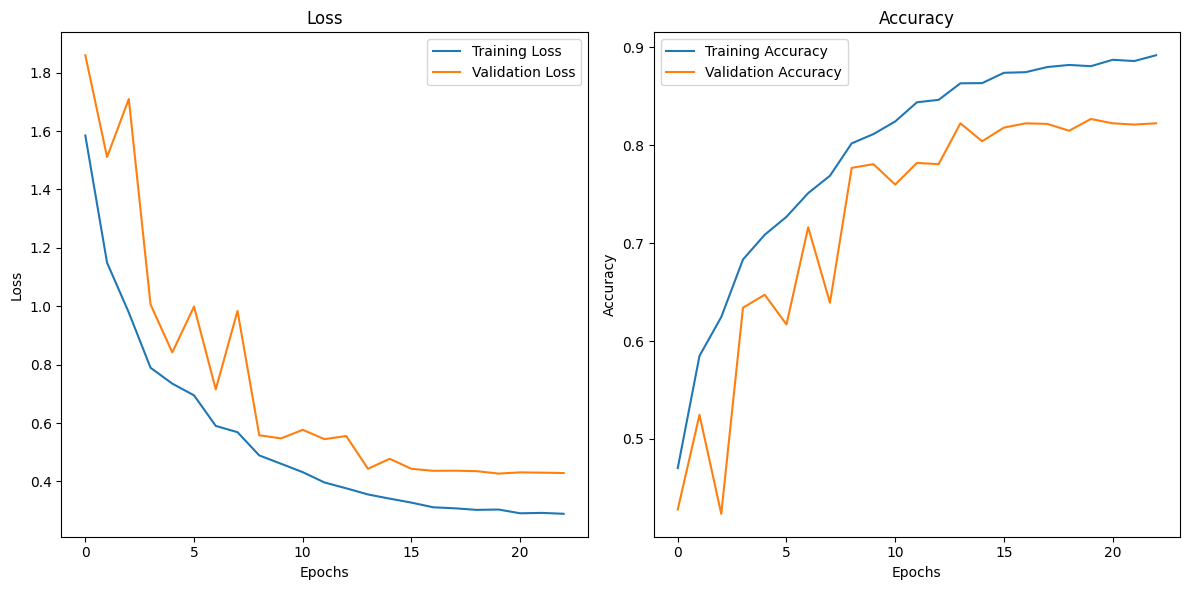

In [22]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.8710 - loss: 0.3263
Test Loss: 0.431903600692749
Test Accuracy: 0.8274336457252502


Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89        89
         1.0       0.82      0.85      0.83       203
         2.0       0.75      0.68      0.71        90
         3.0       0.84      0.85      0.85       114
         4.0       0.89      0.90      0.90       691
         5.0       0.64      0.64      0.64       125
         6.0       0.78      0.76      0.77       158
         7.0       0.72      0.66      0.69       112

    accuracy                           0.83      1582
   macro avg       0.79      0.78      0.78      1582
weighted avg       0.83      0.83      0.83      1582

Confusion Matrix:
[[ 80   2   5   2   0   0   0   0]
 [  3 172  14  14   0   0   0   0]
 [  7  20  61   2   0   0   0   0]
 [  1  15   1  97   0 

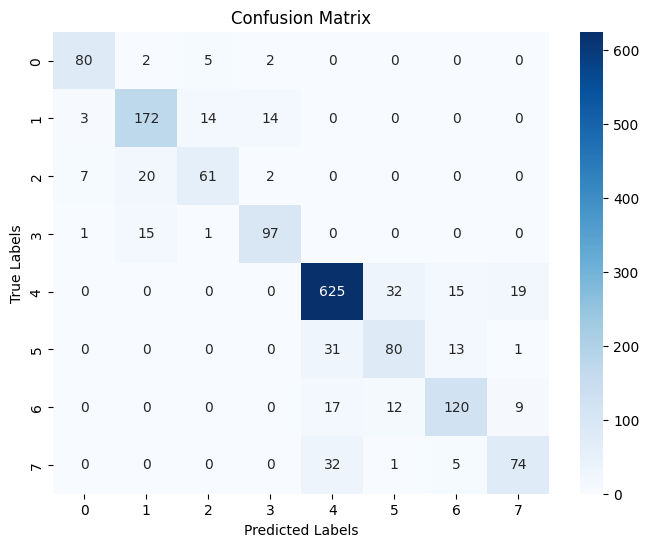

In [20]:
# Predict on the test set
y_test_predicted = best_model.predict([X_test, csv_test])
y_test_predicted = [float(el.argmax()) for el in y_test_predicted]

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate([X_test, csv_test], y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}\n\n')

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_predicted))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_predicted)

# Display confusion matrix as text
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
